In [1]:
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.21G/2.29G [00:20<00:02, 39.2MB/s]
100% 2.29G/2.29G [00:20<00:00, 121MB/s] 


In [4]:
# extracting the compressed dataset
from zipfile import ZipFile

dataset = "/content/chest-xray-pneumonia.zip"

with ZipFile(dataset , "r") as zip:
  zip.extractall()
  print("The dataset is extracted")


The dataset is extracted


In [5]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models

In [7]:
import os

print(len(os.listdir("/content/chest_xray/train")))
print(os.listdir("/content/chest_xray/train"))

print(len(os.listdir("/content/chest_xray/test")))
print(os.listdir("/content/chest_xray/test"))

print(len(os.listdir("/content/chest_xray/val")))
print(os.listdir("/content/chest_xray/val"))

2
['NORMAL', 'PNEUMONIA']
2
['NORMAL', 'PNEUMONIA']
2
['NORMAL', 'PNEUMONIA']


Data Preprocessing

(1858, 2090)


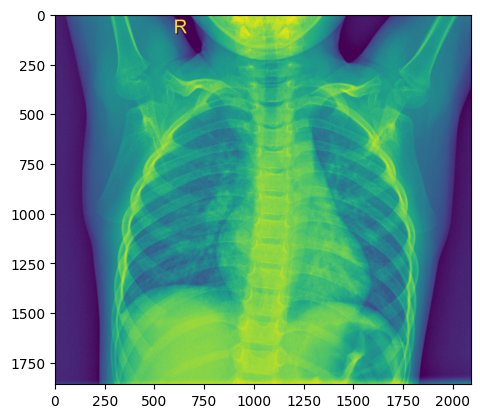

(760, 1152)


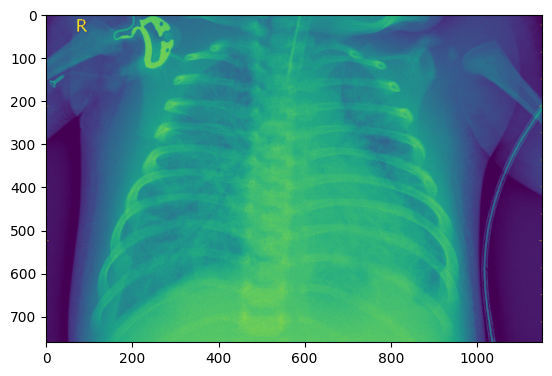

In [8]:
# Dataset Path

base_dir = "/content/chest_xray/train"

image_path = "/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
image_path2 = "/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"

img = mpimg.imread("/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg")

print(img.shape)
#Display the image
plt.imshow(img)

plt.show()

img2 = mpimg.imread(image_path2)

print(img2.shape)
plt.imshow(img2)



In [9]:
image_path = "/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
#Read the image

img = mpimg.imread(image_path)

print(img)

[[ 22  24  24 ...  96  94  93]
 [ 23  24  24 ...  97  94  92]
 [ 24  24  23 ...  99  96  94]
 ...
 [ 49  50  48 ... 119 119 119]
 [ 50  52  53 ... 123 124 123]
 [ 52  53  54 ... 129 128 127]]


In [ ]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train Generator
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(224,224),
    batch_size=32,
    subset="training",
    class_mode="binary"
)

Found 4173 images belonging to 2 classes.


In [ ]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(224,224),
    batch_size=32,
    subset="validation",
    class_mode="binary"
)

Found 1043 images belonging to 2 classes.


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(2, 2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,795,649 (182.33 MB)

 Trainable params: 47,795,649 (182.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 381ms/step - accuracy: 0.8110 - loss: 1.0447 - val_accuracy: 0.9453 - val_loss: 0.1323
Epoch 2/5
  1/130 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 1.0000 - loss: 0.0431

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 1.0000 - loss: 0.0431 - val_accuracy: 0.9482 - val_loss: 0.1290
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.9743 - loss: 0.0740 - val_accuracy: 0.9570 - val_loss: 0.1056
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9688 - loss: 0.1919 - val_accuracy: 0.9570 - val_loss: 0.1089
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - accuracy: 0.9857 - loss: 0.0452 - val_accuracy: 0.9590 - val_loss: 0.1173


In [ ]:
model.evaluate(validation_generator)

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 287ms/step - accuracy: 0.9576 - loss: 0.1375


[0.121439628303051, 0.9578139781951904]